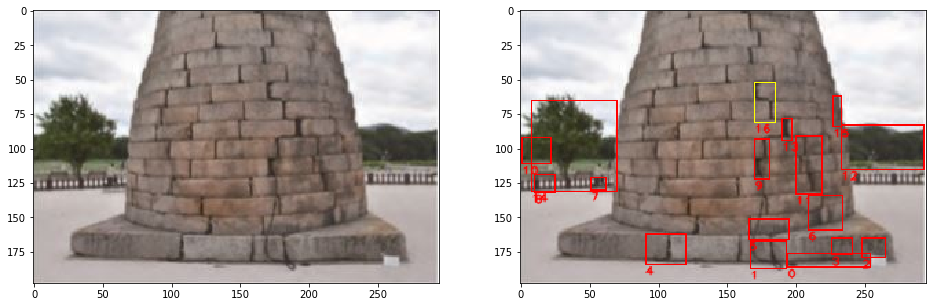

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os

import IPython

import util.DG_FileSystem as dg_fs
import util.DG_CSD_ErosionDetection as dg_csd_ed
import util.DG_ClassWrapper as dg_cw

file_path_list, frame_list = dg_fs.openImagesFromDir('../res')

# 프로그램을 중간에 중지시키기 위한 용도
breakFlag = False

# 사전 준비
if not os.path.exists(f"./out/p"):  os.mkdir(f"./out/p")
if not os.path.exists(f"./out/np"): os.mkdir(f"./out/np")

for file_path, frame in zip(file_path_list, frame_list):
    frame_cut_list, box_list = dg_csd_ed.findContoursFromMask(frame, dg_csd_ed.findHoles(frame))

    # 저장할때 용이하게 하기 위해.
    file_name, file_extension = os.path.splitext(os.path.basename(file_path))

    frame_raw = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)

    for frame_cut, box, idx in zip(frame_cut_list, box_list, range(len(frame_cut_list))):
        # IPython(Jupyter notebook)에서 한정.
        IPython.display.clear_output()

        # 0. Plot image with bounding boxes
        x,y,w,h = box
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,255), 1)
        cv2.putText(frame, f'{idx}', (x,y+h+8), cv2.FONT_HERSHEY_PLAIN, 0.6, (0,0,255), lineType=cv2.LINE_AA)
        fig, axes = plt.subplots(1,2, figsize=(16,12))
        axes[0].imshow(frame_raw)
        axes[1].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 1)

        # 1. 선호/비선호 조사
        ans = input(f"idx:{idx} 선호/비선호 [y/n] >>>").lower()
        if not ans or not (ans in "yn"):
            # 1.1. 혹시모르니 중단 전, 한 번 더 확인.
            ans = input(f"(잘못된 입력) idx:{idx} 선호/비선호 [y/n] >>>").lower()
            if not ans or not (ans in "yn"):
                breakFlag = True
                break
        doPrefer = ans == 'y'

        # 2. 선호 데이터일 경우...
        if doPrefer:
            # 2.1. 클래스 조사
            label = input(f"idx:{idx} label:str 입력 >>> ")

            # 2.2. 클래스에 대한 폴더가 없을 경우, 생성
            if not os.path.exists(f"./out/p/{label}"):
                os.mkdir(f"./out/p/{label}")
            
            # 2.3. 클래스 폴더에 저장
            cv2.imwrite(f"./out/p/{label}/{file_name}_{idx}_cx{x+w//w}cy{y+h//2}{file_extension}", frame_cut)
            
        # 3. 비선호 데이터의 경우, 비선호 폴더에 저장
        else:
            cv2.imwrite(f"./out/np/{file_name}_{idx}{file_extension}", frame_cut)

    if breakFlag: break
print(f"finished. (aborted:{breakFlag})")